In [1]:
import torch
from datasets.nsd import NaturalScenesDataset
from datasets.nsd_features import NSDFeaturesDataset
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from utils.img_utils import save_images
from sklearn.metrics import pairwise_distances
from sklearn import manifold
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

/home/diego/miniconda3/envs/braindive/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

subject = 1
data_root = './data/'
roi = "PPA"
hemisphere = 'right'
seed = 0

nsd = NaturalScenesDataset(
    root=data_root,
    subject=subject,
    partition="train",
    hemisphere=hemisphere,
    roi=roi,
)

# Load index and inverted index
f = os.path.join(data_root, f'subj{subject:02d}/index_train.json')
index = json.load(open(f, 'r'))
f = os.path.join(data_root, f'subj{subject:02d}/inverted_index_train.json')
inv_index = json.load(open(f, 'r'))

feature_extractor_type = "clip_1_5"
metric = 'cosine'
n_neighbors = 0

dataset = NSDFeaturesDataset(
    nsd=nsd,
    feature_extractor_type=feature_extractor_type,
    predict_average=True,
    metric=metric,
    n_neighbors=n_neighbors,
    seed=seed,
    device=device,
    keep_features=True,
)

Computing targets...: 100%|██████████| 9841/9841 [00:10<00:00, 930.07it/s] 


Computing low dimensional representation...
Done.


In [3]:
encoder = LinearRegression().fit(dataset.features, dataset.targets)
y_pred = encoder.predict(dataset.features)
metric = encoder.score(dataset.features, dataset.targets)
print(f"R^2: {round(metric, 4)}")

R^2: 0.5257


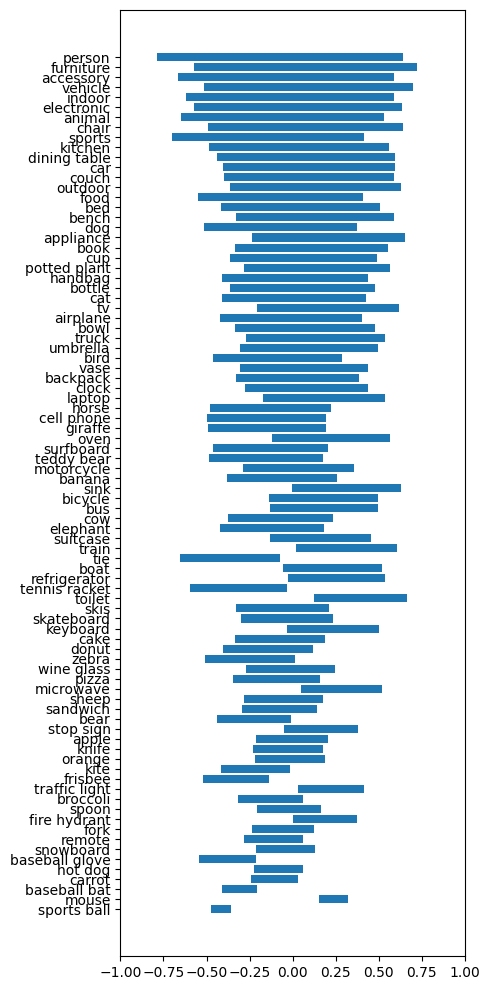

In [25]:
# Load objects
objects = index.keys()

targets = y_pred
num_inputs = 50

objs = []
mins = []
maxs = []
for object in objects:
    try:
        obj_indices = index[object]
        obj_targets = np.sort(targets[obj_indices])
        mins.append(obj_targets[:num_inputs].mean())
        maxs.append(obj_targets[-num_inputs:].mean())
        objs.append(object)
    except:
        pass

effect = np.array(maxs) - np.array(mins)
order = np.argsort(effect)
order = order[effect[order] != 0]
objs = np.array(objs)[order]
mins = np.array(mins)[order]
maxs = np.array(maxs)[order]
effect = np.array(effect)[order]

f = plt.figure(figsize=(5, 10))
plt.barh(objs, effect, left=mins)
plt.xlim(-1, 1)
plt.tight_layout()
plt.show()

Found 1060 images
[('car', 247), ('train', 236), ('truck', 217), ('airplane', 213), ('bus', 155), ('boat', 124), ('outdoor', 111), ('motorcycle', 67), ('bicycle', 46), ('furniture', 38), ('stop sign', 36), ('traffic light', 34), ('accessory', 24), ('chair', 19), ('indoor', 18), ('clock', 16), ('parking meter', 16), ('fire hydrant', 15), ('electronic', 11), ('bench', 11), ('umbrella', 9), ('potted plant', 8), ('kitchen', 8), ('backpack', 8), ('food', 7), ('tv', 7), ('dining table', 7), ('suitcase', 6), ('bottle', 5), ('bed', 5), ('laptop', 4), ('cup', 4), ('handbag', 4), ('sports', 4), ('surfboard', 4), ('cell phone', 3), ('couch', 3), ('appliance', 2), ('orange', 2), ('book', 2), ('hot dog', 2), ('keyboard', 2), ('cake', 1), ('wine glass', 1), ('sink', 1), ('tie', 1), ('toilet', 1), ('refrigerator', 1), ('microwave', 1), ('apple', 1), ('banana', 1)]
0.68858206
-0.42020306


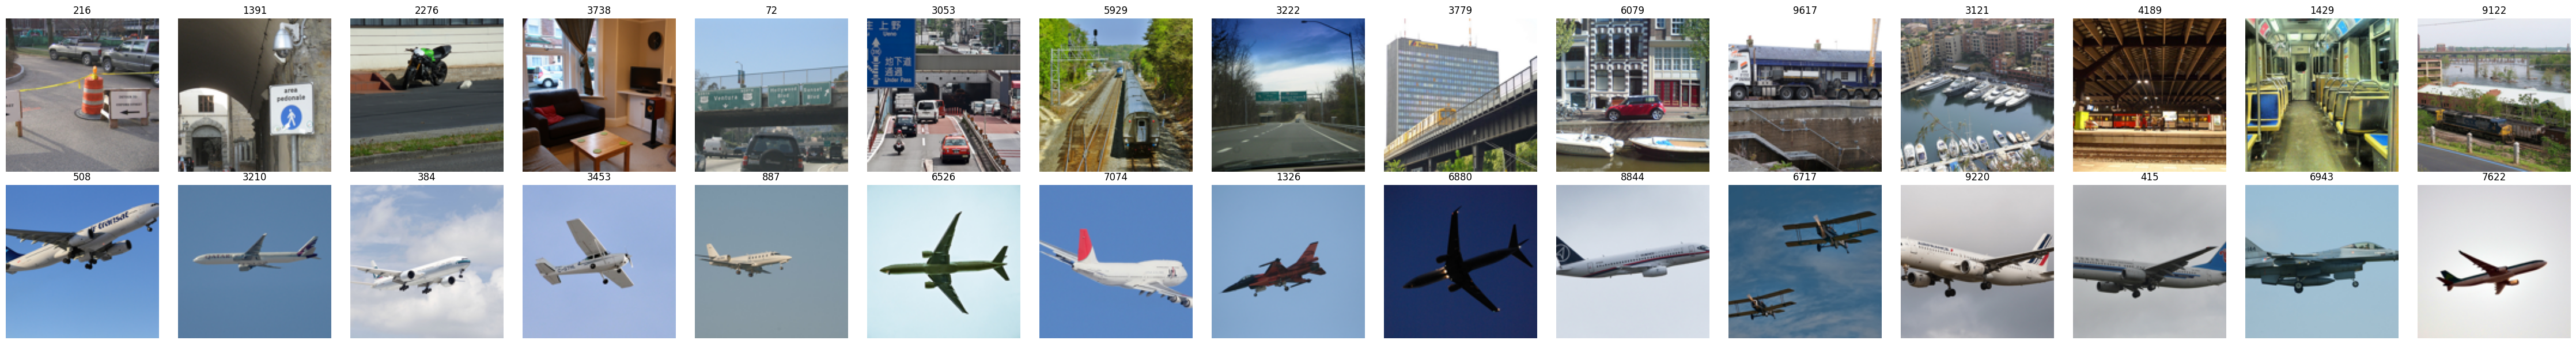

In [57]:
positives = ['vehicle']
negatives = ['person', 'animal']

remaining_negatives = {}
all_indices = set()
for positive in positives:
    pos = inv_index[positive]
    for p in pos:
        categories = index[str(p)]
        rem = []
        keep = True
        for c in categories:
            if c in negatives:
                keep = False
            elif c != positive:
                rem.append(c)
        if keep:
            all_indices.add(p)
            for r in rem:
                remaining_negatives.setdefault(r, 0)
                remaining_negatives[r] += 1
all_indices = np.array(list(all_indices))
print(f'Found {len(all_indices)} images')
remaining_negatives = [(k,v) for k, v in sorted(remaining_negatives.items(), key=lambda item: item[1], reverse=True)]
print(remaining_negatives)

targets = y_pred
targets = targets[all_indices]
num_inputs = 50

# Select Max-EIs
max_eis_idx_sample = np.argsort(targets)[-num_inputs:]
print(targets[max_eis_idx_sample].mean())
max_eis_idx_sample = all_indices[max_eis_idx_sample]
max_eis_images = [Image.open(f'{data_root}{nsd.df.iloc[max_eis_idx_sample[i]]["filename"]}') for i in range(num_inputs)]

# Select Min-EIs
min_eis_idx_sample = np.argsort(targets)[:num_inputs]
print(targets[min_eis_idx_sample].mean())
min_eis_idx_sample = all_indices[min_eis_idx_sample]
min_eis_images = [Image.open(f'{data_root}{nsd.df.iloc[min_eis_idx_sample[i]]["filename"]}') for i in range(num_inputs)]

fig, axs = plt.subplots(2, 15, figsize=(45, 6))
for i in range(15):
    axs[0, i].imshow(max_eis_images[i].resize((128, 128)))
    axs[0, i].axis("off")
    axs[0, i].set_title(max_eis_idx_sample[i])
    axs[1, i].imshow(min_eis_images[i].resize((128, 128)))
    axs[1, i].axis("off")
    axs[1, i].set_title(min_eis_idx_sample[i])
plt.tight_layout()
plt.show()

In [58]:
pos_str = '_'.join(positives)
neg_str = '_'.join(negatives)
query = f'{pos_str}_not_{neg_str}'

folder = f'./outputs/{subject}_{roi}_{hemisphere}/{query}/max'
save_images(max_eis_images, folder)

folder = f'./outputs/{subject}_{roi}_{hemisphere}/{query}/min'
save_images(min_eis_images, folder)